# Patient Like Me - End to End

In [10]:
# !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.20.3
# !pip install fastprogress
# !pip install ollama
# !ollama pull llama3
# !pip install llama-index==0.10.32
# !pip install langchain
# !pip install langchain_community
# !pip install faiss-cpu

In [32]:
import json
import math
import pickle
import warnings
from collections import Counter
from io import StringIO  # Python 3

import boto3
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict, load_dataset, concatenate_datasets
from fastprogress.fastprogress import master_bar, progress_bar
from sagemaker import get_execution_role
from sklearn.metrics import (average_precision_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from tqdm import tqdm, auto
from transformers import (AdamW, AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, TextClassificationPipeline, Trainer, TrainingArguments,
                          get_scheduler, load_metric, modeling_outputs)


ImportError: cannot import name 'load_metric' from 'transformers' (/opt/conda/lib/python3.9/site-packages/transformers/__init__.py)

In [3]:
bucket_name = 'chianglab-dataderivatives'
file_path = "mimic-iv-ed-2.2/text_repr.json"

s3 = boto3.resource('s3')
content_object = s3.Object(bucket_name, file_path)
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
df = pd.DataFrame(json_content).T

df['eddischarge'] = [1 if 'admitted' in s.lower() else 0 for s in df['eddischarge']] # admitted = 1, Home = 0
df['medrecon'] = df['medrecon'].fillna("The patient was previously not taking any medications.")
df['pyxis'] = df['pyxis'].fillna("The patient did not receive any medications.")
df['vitals'] = df['vitals'].fillna("The patient had no vitals recorded")
df['codes'] = df['codes'].fillna("The patient received no diagnostic codes")
df = df.drop("admission",axis=1)
df = df.drop("discharge",axis=1)
df = df.drop("eddischarge_category",axis=1)
df['ID'] = df.arrival.astype(str).str.split().str[1].replace(",", " ", regex=True).to_list()
df["patient_info"] = df["arrival"] + " " + df["triage"] + " " + df["medrecon"] + " " + df["vitals"] + " " + df["codes"] + " " + df["pyxis"]
df = df[[col for col in df.columns if col != 'eddischarge'] + ['eddischarge']] # rearrange column to the end
df

,arrival,triage,medrecon,vitals,codes,pyxis,ID,patient_info,eddischarge
33258284,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.4, pulse was 70....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient did not receive any medications.,10000032,"Patient 10000032, a 52 year old white female, ...",1
38112554,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.9, pulse was 88....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",1
35968195,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 99.4, pulse was 105...",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",1
32952584,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 97.8, pulse was 87....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",0
39399961,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.7, pulse was 77....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",1
...,...,...,...,...,...,...,...,...,...
34149746,"Patient 19999784, a 57 year old black/african ...","At triage: temperature was 98.8, pulse was 92....",The patient was previously taking the followin...,The patient had the following vitals: At 2119-...,The patient received the following diagnostic ...,The patient received the following medications...,19999784,"Patient 19999784, a 57 year old black/african ...",1
35692999,"Patient 19999784, a 57 year old black/african ...","At triage: temperature was 98.6, pulse was 80....",The patient was previously not taking any medi...,The patient had the following vitals: At 2119-...,The patient received the following diagnostic ...,The patient did not receive any medications.,19999784,"Patient 19999784, a 57 year old black/african ...",1
32917002,"Patient 19999828, a 46 year old white female, ...","At triage: temperature was 96.6, pulse was 112...",The patient was previously taking the followin...,The patient had the following vitals: At 2149-...,The patient received the following diagnostic ...,The patient received the following medications...,19999828,"Patient 19999828, a 46 year old white female, ...",1
30712109,"Patient 19999828, a 46 year old white female, ...","At triage: temperature was 98.1, pulse was 83....",The patient was previously taking the followin...,The patient had the following vitals: At 2147-...,The patient received the following diagnostic ...,The patient received the following medications...,19999828,"Patient 19999828, a 46 year old white female, ...",1


In [4]:
df = df.drop("arrival",axis=1)
df = df.drop("triage",axis=1)
df = df.drop("medrecon",axis=1)
df = df.drop("vitals",axis=1)
df = df.drop("codes",axis=1)
df = df.drop("pyxis",axis=1)

# Main execution
from sklearn.model_selection import train_test_split

# Sample 100,000 rows from the original DataFrame
temp = df.sample(10000)

# KNN where we bootstrap a group of embeddings and get a more robust prediciton

In [5]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, precision_recall_curve
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
from collections import Counter
import warnings
import math
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="A parameter name that contains `beta` will be renamed internally to `bias`")
warnings.filterwarnings('ignore', message="A parameter name that contains `gamma` will be renamed internally to `weight`")

def encode_texts(texts, tokenizer, model):
    model.eval()
    if torch.cuda.is_available():
        model.to('cuda')
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
            if torch.cuda.is_available():
                encoded_input = {key: val.to('cuda') for key, val in encoded_input.items()}
            output = model(**encoded_input)
            cls_embedding = output.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy())
    return np.vstack(embeddings)

def ts_ss_(v, eps=1e-15, eps2=1e-4):
    # reusable compute
    v_inner = torch.mm(v, v.t())
    vs = v.norm(dim=-1, keepdim=True)
    vs_dot = vs.mm(vs.t())
    # compute triangle(v)
    v_cos = v_inner / vs_dot
    v_cos = v_cos.clamp(-1. + eps2, 1. - eps2)  # clamp to avoid backprop instability
    theta_ = torch.acos(v_cos) + math.radians(10)
    theta_rad = theta_ * math.pi / 180.
    tri = (vs_dot * torch.sin(theta_rad)) / 2.
    # compute sector(v)
    v_norm = (v ** 2).sum(-1, keepdim=True)
    euc_dist = v_norm + v_norm.t() - 2.0 * v_inner
    euc_dist = torch.sqrt(torch.abs(euc_dist) + eps)  # add epsilon to avoid srt(0.)
    magnitude_diff = (vs - vs.t()).abs()
    sec = math.pi * (euc_dist + magnitude_diff) ** 2 * theta_ / 360.
    return tri * sec

def custom_distance(x1, x2):
    v = torch.tensor([x1, x2]).float()
    return ts_ss_(v)[0, 1].item()

def knn(train_data, test_data, tokenizer, model, n_neighbors=5, n_bootstrap=1000):
    # Encode train and test data
    train_embeddings = encode_texts(train_data['patient_info'].tolist(), tokenizer, model)
    test_embeddings = encode_texts(test_data['patient_info'].tolist(), tokenizer, model)

    # Fit KNN with custom metric
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric=custom_distance)
    knn.fit(train_embeddings)

    # Predict using KNN for the test set
    distances, indices = knn.kneighbors(test_embeddings)

    # Aggregate predictions
    predictions = []
    for idx_array in tqdm(indices):
        nearest_labels = train_data.iloc[idx_array]['eddischarge'].tolist()
        label_counts = Counter(nearest_labels)
        total = sum(label_counts.values())
        prob_positive = label_counts[1] / total  # Assuming 1 is the positive class
        predictions.append(prob_positive)

    # Compute metrics
    true_labels = test_data['eddischarge'].tolist()
    auroc_scores = []
    auprc_scores = []
    f1_scores = []

    # Bootstrap for confidence intervals
    for _ in tqdm(range(n_bootstrap)):
        boot_indices = np.random.randint(0, len(predictions), len(predictions))
        boot_predictions = [predictions[i] for i in boot_indices]
        boot_true_labels = [true_labels[i] for i in boot_indices]
        
        auroc_scores.append(roc_auc_score(boot_true_labels, boot_predictions))
        auprc_scores.append(average_precision_score(boot_true_labels, boot_predictions))
        f1_scores.append(f1_score(boot_true_labels, [1 if p > 0.5 else 0 for p in boot_predictions], average='macro'))

    # Calculate mean and 95% confidence intervals
    auroc_mean, auroc_conf = np.mean(auroc_scores), (np.percentile(auroc_scores, 2.5), np.percentile(auroc_scores, 97.5))
    auprc_mean, auprc_conf = np.mean(auprc_scores), (np.percentile(auprc_scores, 2.5), np.percentile(auprc_scores, 97.5))
    f1_mean, f1_conf = np.mean(f1_scores), (np.percentile(f1_scores, 2.5), np.percentile(f1_scores, 97.5))

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()

    return {
        "Predictions": predictions,
        "Metrics": {
            "AUROC": (auroc_mean, auroc_conf),
            "AUPRC": (auprc_mean, auprc_conf),
            "F1": (f1_mean, f1_conf)
        },
        "ROC": (fpr, tpr),
        "PRC": (precision, recall)
    }, true_labels, predictions

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, precision_recall_curve
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
from collections import Counter
import warnings
import math
import matplotlib.pyplot as plt
import faiss

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="A parameter name that contains `beta` will be renamed internally to `bias`")
warnings.filterwarnings('ignore', message="A parameter name that contains `gamma` will be renamed internally to `weight`")

def encode_texts(texts, tokenizer, model, device):
    model.eval()
    model.to(device)
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
            encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
            output = model(**encoded_input)
            cls_embedding = output.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy())
    return np.vstack(embeddings)

def ts_ss_batch(v, eps=1e-15, eps2=1e-4):
    # Compute pairwise distances for a batch of vectors
    v_inner = torch.mm(v, v.t())
    vs = v.norm(dim=-1, keepdim=True)
    vs_dot = vs.mm(vs.t())
    
    v_cos = v_inner / vs_dot
    v_cos = v_cos.clamp(-1. + eps2, 1. - eps2)
    theta_ = torch.acos(v_cos) + math.radians(10)
    theta_rad = theta_ * math.pi / 180.
    tri = (vs_dot * torch.sin(theta_rad)) / 2.
    
    v_norm = (v ** 2).sum(-1, keepdim=True)
    euc_dist = v_norm + v_norm.t() - 2.0 * v_inner
    euc_dist = torch.sqrt(torch.abs(euc_dist) + eps)
    magnitude_diff = (vs - vs.t()).abs()
    sec = math.pi * (euc_dist + magnitude_diff) ** 2 * theta_ / 360.
    
    return tri * sec

class CustomFaissIndex:
    def __init__(self, vectors, device):
        self.vectors = torch.tensor(vectors).float().to(device)
        self.device = device

    def search(self, query_vectors, k):
        query_vectors = torch.tensor(query_vectors).float().to(self.device)
        distances = ts_ss_batch(torch.cat([self.vectors, query_vectors]))
        distances = distances[-query_vectors.shape[0]:, :self.vectors.shape[0]]
        topk_distances, topk_indices = torch.topk(distances, k, dim=1, largest=False)
        return topk_distances.cpu().numpy(), topk_indices.cpu().numpy()

def knn(train_data, test_data, tokenizer, model, n_neighbors=5, n_bootstrap=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encode train and test data
    train_embeddings = encode_texts(train_data['patient_info'].tolist(), tokenizer, model, device)
    test_embeddings = encode_texts(test_data['patient_info'].tolist(), tokenizer, model, device)

    # Use custom FAISS-like index with GPU
    index = CustomFaissIndex(train_embeddings, device)

    # Predict using KNN for the test set
    distances, indices = index.search(test_embeddings, n_neighbors)

    # Aggregate predictions
    predictions = []
    for idx_array in tqdm(indices):
        nearest_labels = train_data.iloc[idx_array]['eddischarge'].tolist()
        label_counts = Counter(nearest_labels)
        total = sum(label_counts.values())
        prob_positive = label_counts[1] / total  # Assuming 1 is the positive class
        predictions.append(prob_positive)

# Compute metrics
    true_labels = test_data['eddischarge'].tolist()
    auroc_scores = []
    auprc_scores = []
    f1_scores = []

    # Bootstrap for confidence intervals
    for _ in tqdm(range(n_bootstrap)):
        boot_indices = np.random.randint(0, len(predictions), len(predictions))
        boot_predictions = [predictions[i] for i in boot_indices]
        boot_true_labels = [true_labels[i] for i in boot_indices]
        
        auroc_scores.append(roc_auc_score(boot_true_labels, boot_predictions))
        auprc_scores.append(average_precision_score(boot_true_labels, boot_predictions))
        f1_scores.append(f1_score(boot_true_labels, [1 if p > 0.5 else 0 for p in boot_predictions], average='macro'))

    # Calculate mean and 95% confidence intervals
    auroc_mean, auroc_conf = np.mean(auroc_scores), (np.percentile(auroc_scores, 2.5), np.percentile(auroc_scores, 97.5))
    auprc_mean, auprc_conf = np.mean(auprc_scores), (np.percentile(auprc_scores, 2.5), np.percentile(auprc_scores, 97.5))
    f1_mean, f1_conf = np.mean(f1_scores), (np.percentile(f1_scores, 2.5), np.percentile(f1_scores, 97.5))

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()

    return {
        "Predictions": predictions,
        "Metrics": {
            "AUROC": (auroc_mean, auroc_conf),
            "AUPRC": (auprc_mean, auprc_conf),
            "F1": (f1_mean, f1_conf)
        },
        "ROC": (fpr, tpr),
        "PRC": (precision, recall)
    }, true_labels, predictions

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Using device: cuda


100%|██████████| 1000/1000 [00:06<00:00, 150.14it/s]


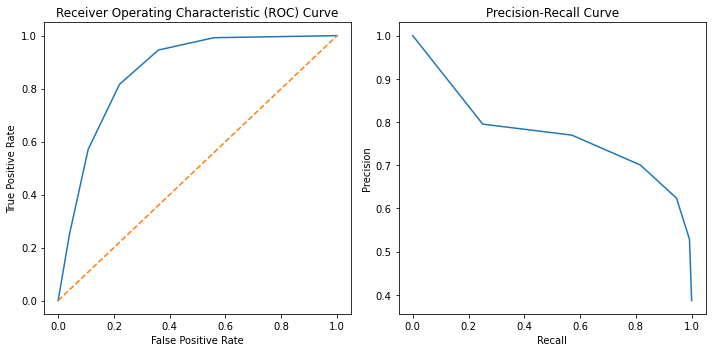

Results:
AUROC: 0.867 (95% CI: 0.850-0.882)
AUPRC: 0.727 (95% CI: 0.692-0.761)
F1: 0.789 (95% CI: 0.771-0.808)


In [14]:
# Load the pre-trained model and tokenizer
model_name = 'bert-base-uncased'  # or your preferred model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Run KNN
results, true_labels, predictions = knn(
    train_set, 
    test_set, 
    tokenizer, 
    model, 
    n_neighbors=5, 
    n_bootstrap=1000
)

# Print results
print("Results:")
for metric, (mean, conf) in results['Metrics'].items():
    print(f"{metric}: {mean:.3f} (95% CI: {conf[0]:.3f}-{conf[1]:.3f})")

Using device: cuda


100%|██████████| 1000/1000 [00:06<00:00, 151.21it/s]


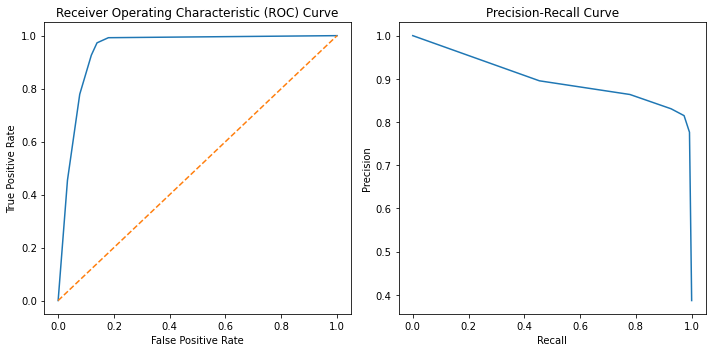

Results:
AUROC: 0.946 (95% CI: 0.936-0.956)
AUPRC: 0.866 (95% CI: 0.838-0.890)
F1: 0.895 (95% CI: 0.881-0.909)


In [19]:
# Load the pre-trained model and tokenizer
model_name = "medicalai/ClinicalBERT"  # or your preferred model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Run KNN
results2, true_labels2, predictions2 = knn(
    train_set, 
    test_set, 
    tokenizer, 
    model, 
    n_neighbors=5, 
    n_bootstrap=1000
)

# Print results
print("Results:")
for metric, (mean, conf) in results2['Metrics'].items():
    print(f"{metric}: {mean:.3f} (95% CI: {conf[0]:.3f}-{conf[1]:.3f})")

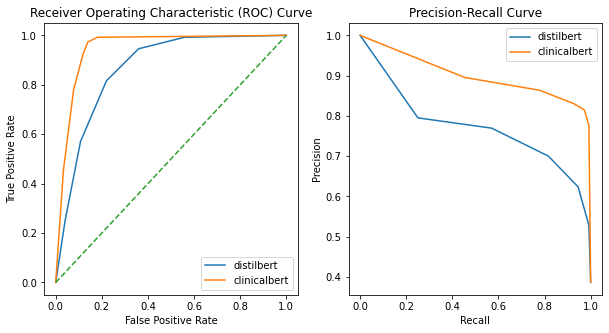

In [20]:
# distilbert
fpr, tpr, _ = roc_curve(true_labels, predictions)
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# clinicalbert
fpr2, tpr2, _ = roc_curve(true_labels2, predictions2)
precision2, recall2, _ = precision_recall_curve(true_labels2, predictions2)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label="distilbert")
plt.plot(fpr2, tpr2, label="clinicalbert")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="distilbert")
plt.plot(recall2, precision2, label="clinicalbert")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.legend()

# one sample

In [29]:
def ts_ss_(v, eps=1e-15, eps2=1e-4):
    # reusable compute
    v_inner = torch.mm(v, v.t())
    vs = v.norm(dim=-1, keepdim=True)
    vs_dot = vs.mm(vs.t())
    # compute triangle(v)
    v_cos = v_inner / vs_dot
    v_cos = v_cos.clamp(-1. + eps2, 1. - eps2)  # clamp to avoid backprop instability
    theta_ = torch.acos(v_cos) + math.radians(10)
    theta_rad = theta_ * math.pi / 180.
    tri = (vs_dot * torch.sin(theta_rad)) / 2.
    # compute sector(v)
    v_norm = (v ** 2).sum(-1, keepdim=True)
    euc_dist = v_norm + v_norm.t() - 2.0 * v_inner
    euc_dist = torch.sqrt(torch.abs(euc_dist) + eps)  # add epsilon to avoid srt(0.)
    magnitude_diff = (vs - vs.t()).abs()
    sec = math.pi * (euc_dist + magnitude_diff) ** 2 * theta_ / 360.
    return tri * sec

def encode_texts(model_name, texts):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
            encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
            output = model(**encoded_input)
            cls_embedding = output.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy())
    print("Embeddings are generated")
    return np.vstack(embeddings)

def knn(query_text, data_source, model_name, n_neighbors=5, sample_size=1000):
    # Bootstrap a dataframe
    df = pd.DataFrame(data_source)
    
    # Encode all text data
    all_embeddings = encode_texts(model_name, df['patient_info'].tolist())
    
    # Encode the query text
    query_embedding = encode_texts(model_name, [query_text])
    
    # Sample indices
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    # Get sample data
    sample_embeddings = all_embeddings[sample_indices]
    
    # Convert embeddings to PyTorch tensors
    sample_embeddings_tensor = torch.tensor(sample_embeddings).float()
    query_embedding_tensor = torch.tensor(query_embedding).float()
    
    # Compute TSS similarities
    combined_embeddings = torch.cat([query_embedding_tensor, sample_embeddings_tensor])
    tss_matrix = ts_ss_(combined_embeddings)
    similarities = 1 / (1 + tss_matrix[0, 1:])  # Convert distances to similarities
    
    # Sort similarities and get top n_neighbors
    top_indices = torch.argsort(similarities, descending=True)[:n_neighbors]
    top_similarities = similarities[top_indices].numpy()
    
    # Plot the distribution of similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities.numpy(), kde=True)
    plt.title('Distribution of TSS Similarities')
    plt.xlabel('TSS Similarity')
    plt.ylabel('Frequency')
    plt.show()
    
    return top_similarities

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Embeddings are generated


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Embeddings are generated


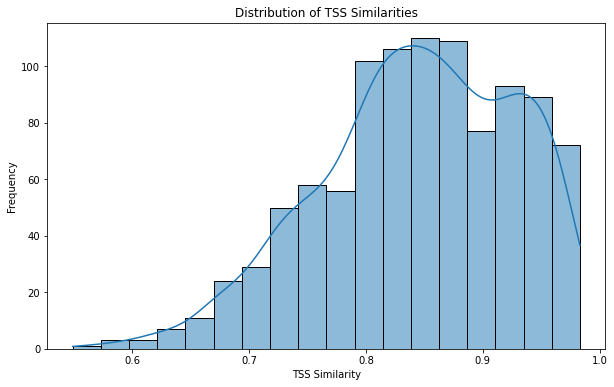

Top 5 TSS similarities: [0.983229   0.98124516 0.9812207  0.9798028  0.97811586]


In [30]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "bert-base-uncased"
similarities = knn(query_text, data_source, model_name)

print(f"Top {len(similarities)} TSS similarities:", similarities)

100%|██████████| 10000/10000 [01:11<00:00, 139.42it/s]


Embeddings are generated


100%|██████████| 1/1 [00:00<00:00, 131.22it/s]


Embeddings are generated


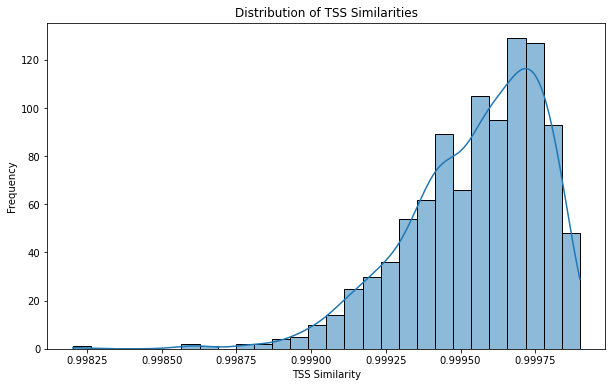

Top 5 TSS similarities: [0.9998994  0.99988854 0.99988675 0.9998828  0.99987507]


In [31]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "medicalai/ClinicalBERT"
similarities = knn(query_text, data_source, model_name)

print(f"Top {len(similarities)} TSS similarities:", similarities)